
# Iris Flower Classification (scikit-learn dataset)



## 1. Setup

In [1]:
# !pip install scikit-learn pandas numpy matplotlib seaborn joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from dataclasses import dataclass

from sklearn.datasets import load_iris as sk_load_iris
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

RANDOM_STATE = 42

@dataclass
class Config:
    test_size: float = 0.2
    n_splits: int = 5
    random_state: int = RANDOM_STATE
    output_models_dir: Path = Path("models")
    output_reports_dir: Path = Path("reports")
    output_figures_dir: Path = Path("reports/figures")

cfg = Config()
cfg.output_models_dir.mkdir(parents=True, exist_ok=True)
cfg.output_reports_dir.mkdir(parents=True, exist_ok=True)
cfg.output_figures_dir.mkdir(parents=True, exist_ok=True)


## 2. Load data

In [ ]:

def load_iris_df():
    iris = sk_load_iris(as_frame=True)
    df = iris.frame.copy()
    target_map = {i: name for i, name in enumerate(iris.target_names)}
    df["target"] = df["target"].map(target_map)
    X = df.drop(columns=["target"])
    y = df["target"]
    return X, y

X, y = load_iris_df()
X.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


## 3. Quick EDA

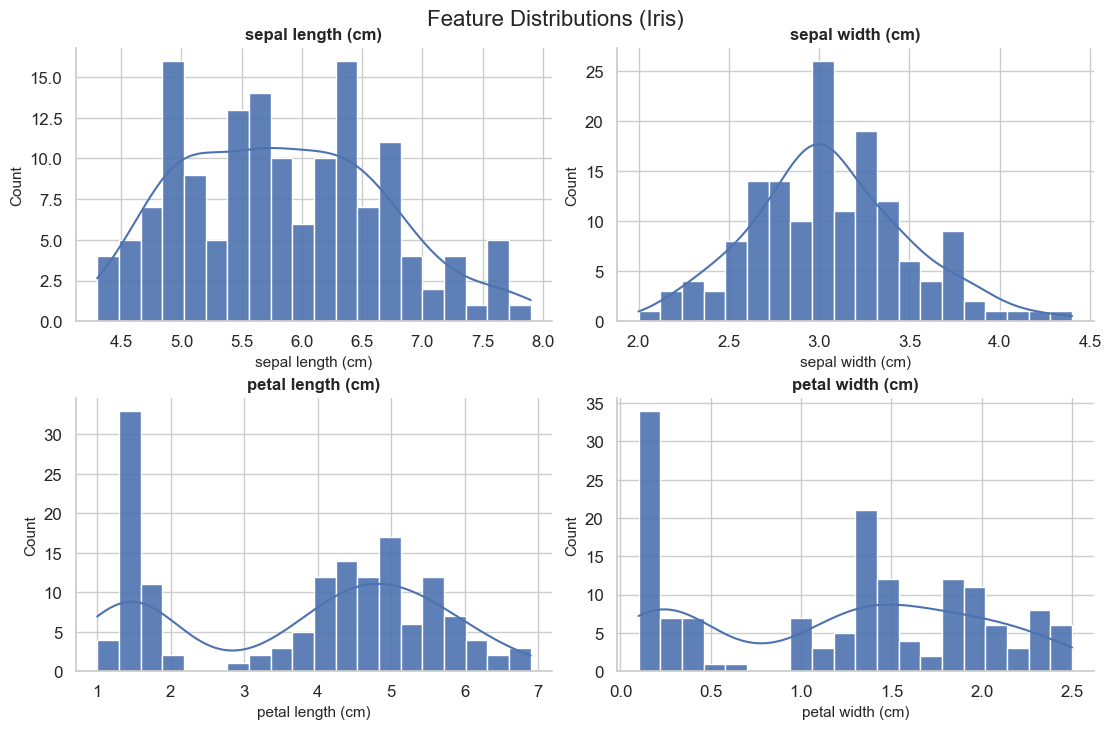

[INFO] Saved histograms to: reports\figures\hist_features.png


In [15]:

# Histograms 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
mpl.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.titleweight": "semibold",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

features = list(X.columns)
n = len(features)
rows, cols = 2, 2

fig, axes = plt.subplots(rows, cols, figsize=(11, 7), constrained_layout=True)

for ax, col in zip(axes.flat, features):
    sns.histplot(
        data=X, x=col, bins=20, kde=True, stat="count",
        edgecolor="white", alpha=0.9, ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel(col) 
    ax.set_ylabel("Count")

fig.suptitle("Feature Distributions (Iris)", y=1.02)

out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / "hist_features.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"[INFO] Saved histograms to: {fig_path}")


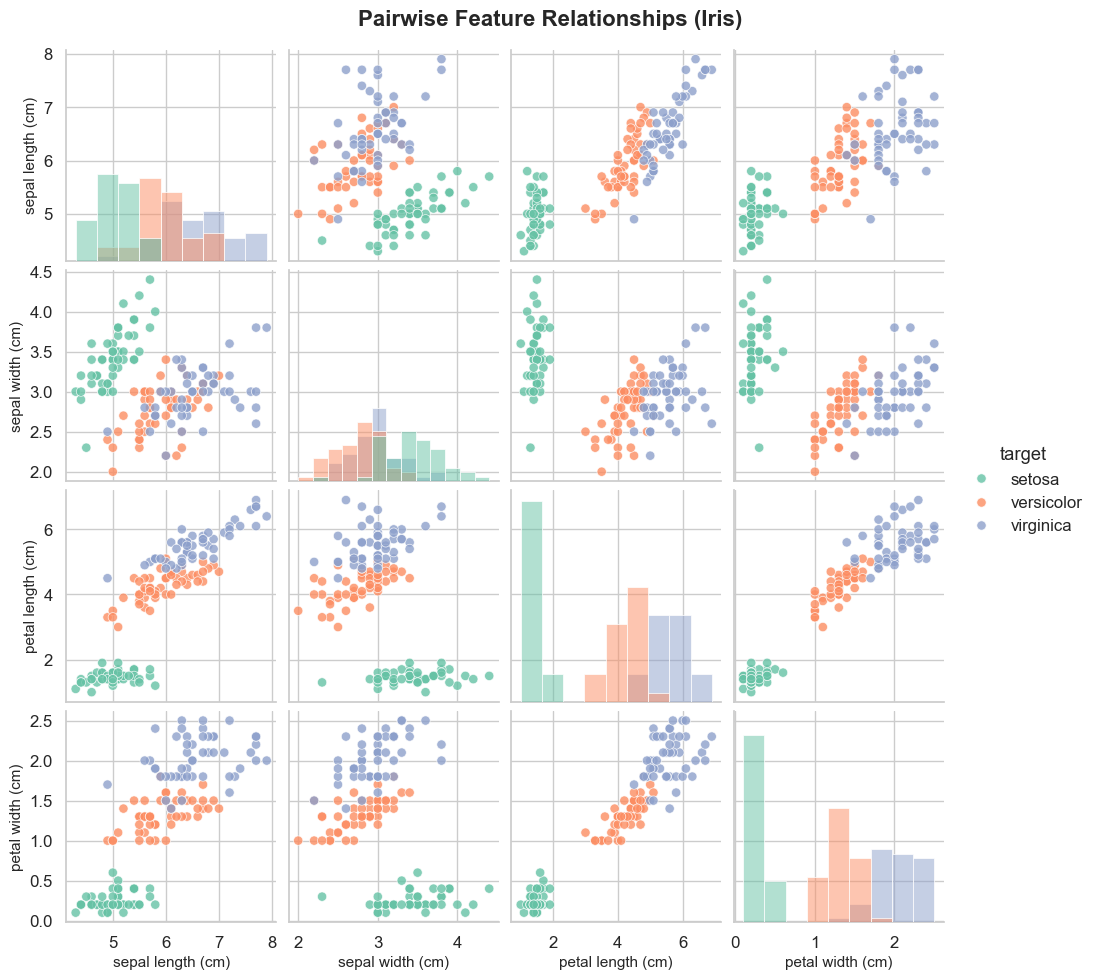

[INFO] Saved pairplot to: reports\figures\pairplot.png


In [17]:

# Pairplot 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
mpl.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.titleweight": "semibold",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

df_plot = X.copy()
df_plot["target"] = y.values

g = sns.pairplot(
    df_plot,
    hue="target",
    diag_kind="hist",
    palette="Set2",
    corner=False,
    plot_kws={"alpha": 0.8, "edgecolor": "white", "s": 45},
    diag_kws={"edgecolor": "white", "linewidth": 0.5},
    height=2.4
)

g.fig.suptitle("Pairwise Feature Relationships (Iris)", y=1.02, fontsize=16, fontweight="semibold")

out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / "pairplot.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"[INFO] Saved pairplot to: {fig_path}")


## 4. Train/Test split

In [18]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=cfg.test_size, stratify=y, random_state=cfg.random_state
)
X_train.shape, X_test.shape


((120, 4), (30, 4))

## 5. Define model pipelines

In [19]:

def build_models():
    scaler = StandardScaler()
    models_scaled = {
        "logreg": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "knn": KNeighborsClassifier(),
        "svc": SVC(probability=True, random_state=RANDOM_STATE),
    }
    pipes = {name: Pipeline(steps=[("scaler", scaler), ("clf", model)]) for name, model in models_scaled.items()}
    pipes["rf"] = Pipeline(steps=[("clf", RandomForestClassifier(random_state=RANDOM_STATE))])
    return pipes

pipes = build_models()
list(pipes.keys())


['logreg', 'knn', 'svc', 'rf']

## 6. Cross-validation model comparison

In [20]:

def cv_compare_models(pipes, X, y, n_splits=cfg.n_splits, seed=cfg.random_state):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rows = []
    for name, pipe in pipes.items():
        scores = cross_val_score(pipe, X, y, cv=skf, scoring="accuracy", n_jobs=-1)
        rows.append({
            "model": name,
            "cv_mean_acc": float(scores.mean()),
            "cv_std_acc": float(scores.std()),
            "folds": n_splits
        })
    return pd.DataFrame(rows).sort_values("cv_mean_acc", ascending=False).reset_index(drop=True)

cv_table = cv_compare_models(pipes, X_train, y_train)
cv_table


,model,cv_mean_acc,cv_std_acc,folds
0,svc,0.966667,0.016667,5
1,logreg,0.958333,0.026352,5
2,knn,0.958333,0.026352,5
3,rf,0.950000,0.031180,5


## 7. Grid search for a strong baseline

In [21]:

def grid_search_best(X_train, y_train):
    base_pipe = Pipeline(steps=[("scaler", StandardScaler()), ("clf", SVC(probability=True))])
    param_grid = [
        {
            "clf": [SVC(probability=True, random_state=RANDOM_STATE)],
            "clf__kernel": ["rbf", "linear"],
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", "auto"],
        },
        {
            "clf": [RandomForestClassifier(random_state=RANDOM_STATE)],
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [None, 3, 5],
            "clf__min_samples_split": [2, 4],
        },
    ]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=skf,
        n_jobs=-1,
        refit=True,
        verbose=0,
    )
    gs.fit(X_train, y_train)
    return gs

gs = grid_search_best(X_train, y_train)
print("Best estimator:", gs.best_estimator_)
print("Best CV accuracy:", round(gs.best_score_, 4))
print("Best params:")
for k, v in gs.best_params_.items():
    print(f"  {k}: {v}")


Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=42))])
Best CV accuracy: 0.975
Best params:
  clf: SVC(probability=True, random_state=42)
  clf__C: 0.1
  clf__gamma: scale
  clf__kernel: linear


## 8. Learning Curve for the best estimator

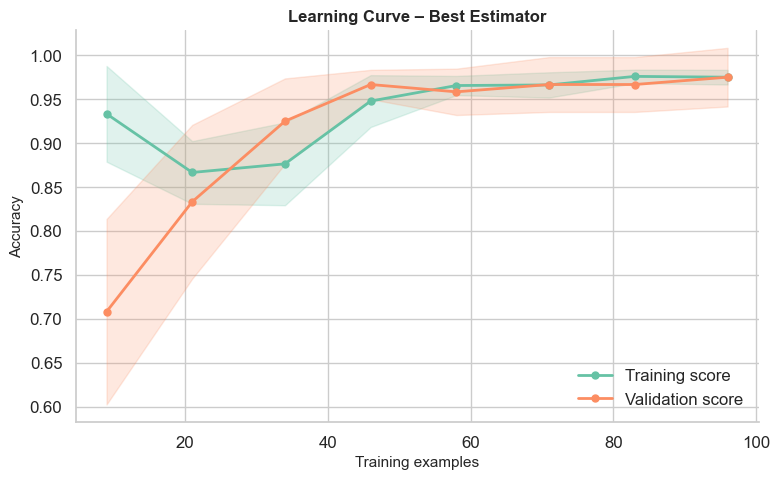

[INFO] Saved learning curve to: reports\figures\learning_curve.png


In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
mpl.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.titleweight": "semibold",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

colors = sns.color_palette("Set2", 2)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_sizes, train_mean, marker="o", linewidth=2, markersize=5, label="Training score", color=colors[0])
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color=colors[0])
ax.plot(train_sizes, val_mean, marker="o", linewidth=2, markersize=5, label="Validation score", color=colors[1])
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color=colors[1])

ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning Curve – Best Estimator")
ax.legend(frameon=False)
fig.tight_layout()

out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / "learning_curve.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"[INFO] Saved learning curve to: {fig_path}")


## 9. Final evaluation on the test set

In [24]:

y_pred = gs.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))
print("Balanced Accuracy:", round(bacc, 4))
print("\nClassification report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9333
Balanced Accuracy: 0.9333

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



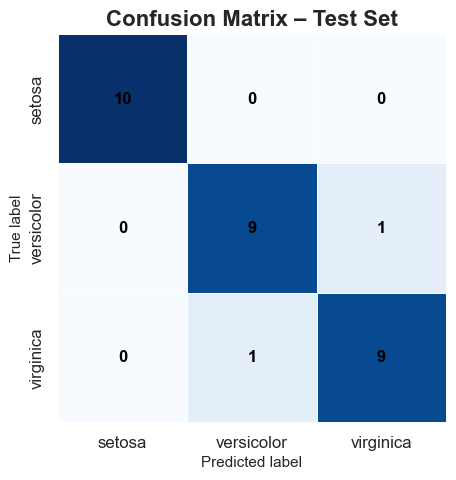

[INFO] Saved confusion matrix to: reports\figures\confusion_matrix.png


In [28]:
# Confusion matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
mpl.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.titleweight": "semibold",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
cm_df = pd.DataFrame(cm, index=gs.classes_, columns=gs.classes_)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12, "weight": "bold", "color": "black"},
    ax=ax
)

ax.set_title("Confusion Matrix – Test Set", fontsize=16, fontweight="semibold")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

fig.tight_layout()
out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / "confusion_matrix.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"[INFO] Saved confusion matrix to: {fig_path}")

## 10. ROC–AUC (One-vs-Rest)

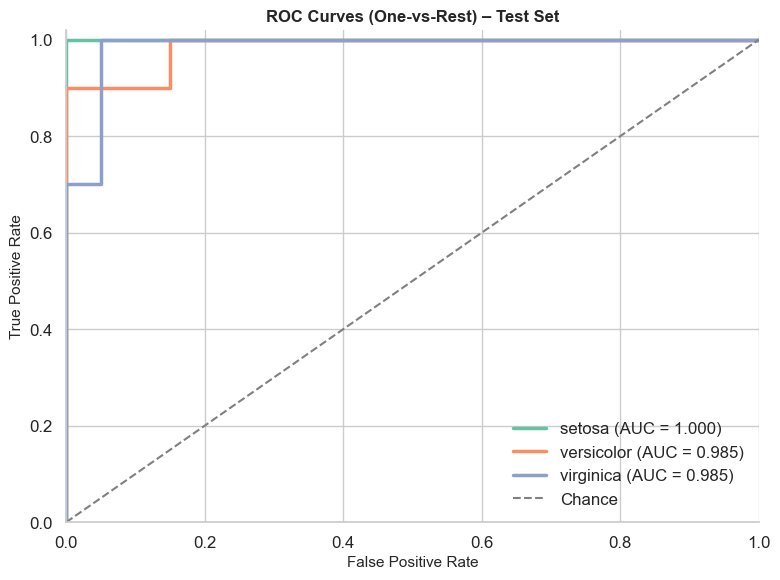

[INFO] Saved ROC curves to: reports\figures\roc_curves.png


In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import numpy as np

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
mpl.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.titleweight": "semibold",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

classes = np.unique(y_test)
palette = sns.color_palette("Set2", n_colors=len(classes))

fig, ax = plt.subplots(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=classes)[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2.5, label=f"{cls} (AUC = {roc_auc:.3f})", color=palette[i])

ax.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", label="Chance")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.02)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves (One-vs-Rest) – Test Set")
ax.legend(frameon=False, loc="lower right")
fig.tight_layout()

out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / "roc_curves.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"[INFO] Saved ROC curves to: {fig_path}")


## 11. Permutation Importance on the test set

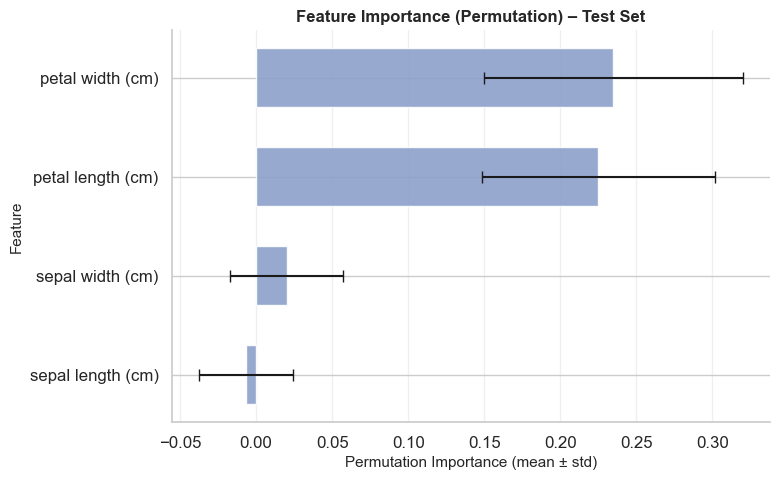

[INFO] Saved feature importance plot to: reports\figures\feature_importance.png


In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
mpl.rcParams.update({
    "figure.titlesize": 16,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.titleweight": "semibold",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

result = permutation_importance(
    gs.best_estimator_, X_test, y_test,
    scoring="accuracy", n_repeats=20, random_state=42, n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=True)

imp_df["importance_std"] = imp_df["importance_std"].fillna(0.0)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(
    imp_df["feature"],
    imp_df["importance_mean"],
    xerr=imp_df["importance_std"],
    height=0.6,
    alpha=0.9,
    edgecolor="white",
    linewidth=1.0,
    capsize=4,
    color=sns.color_palette("Set2")[2]
)

ax.set_xlabel("Permutation Importance (mean ± std)")
ax.set_ylabel("Feature")
ax.set_title("Feature Importance (Permutation) – Test Set")
ax.grid(axis="x", alpha=0.3)
ax.set_axisbelow(True)

fig.tight_layout()
out_dir = Path("reports/figures"); out_dir.mkdir(parents=True, exist_ok=True)
fig_path = out_dir / "feature_importance.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"[INFO] Saved feature importance plot to: {fig_path}")


## 12. Save the fitted model artifact

In [32]:

save_artifact = True  
if save_artifact:
    model_path = cfg.output_models_dir / "best_model.joblib"
    joblib.dump(
        {
            "model": gs.best_estimator_,
            "feature_names": list(X.columns),
            "metrics_test": {"accuracy": float(acc), "balanced_accuracy": float(bacc)},
            "best_cv_accuracy": float(gs.best_score_),
            "best_params": gs.best_params_,
            "data_source": "scikit-learn built-in iris dataset",
        },
        model_path,
    )
    print(f"[INFO] Model saved to: {model_path}")
else:
    print("[INFO] Saving skipped.")


[INFO] Model saved to: models\best_model.joblib
